<a href="https://colab.research.google.com/github/ngngthnhan/Age-Detection/blob/main/Face_Age_Detection_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ngngthnhan","key":"157796d560e3d4652b67ed9de88a937d"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arashnic/faces-age-detection-dataset

 94% 45.0M/47.8M [00:02<00:00, 23.9MB/s]
100% 47.8M/47.8M [00:02<00:00, 16.7MB/s]


In [ ]:
!unzip faces-age-detection-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Train/4047.jpg          
  inflating: Train/4049.jpg          
  inflating: Train/405.jpg           
  inflating: Train/4051.jpg          
  inflating: Train/4052.jpg          
  inflating: Train/4053.jpg          
  inflating: Train/4055.jpg          
  inflating: Train/4056.jpg          
  inflating: Train/4057.jpg          
  inflating: Train/4058.jpg          
  inflating: Train/4059.jpg          
  inflating: Train/406.jpg           
  inflating: Train/4060.jpg          
  inflating: Train/4061.jpg          
  inflating: Train/4062.jpg          
  inflating: Train/4065.jpg          
  inflating: Train/4066.jpg          
  inflating: Train/4068.jpg          
  inflating: Train/4069.jpg          
  inflating: Train/407.jpg           
  inflating: Train/4070.jpg          
  inflating: Train/4072.jpg          
  inflating: Train/4073.jpg          
  inflating: Train/4076.jpg          
  inflating: Train/4078.jpg          

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import os
import seaborn as sns 
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
print(tf.__version__)

2.12.0


In [ ]:
# read the csv file to check out the images and class
data = pd.read_csv('/content/train.csv')
data.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [ ]:
data['Class'].replace(['YOUNG', 'MIDDLE', 'OLD'], [0, 1, 2], inplace = True)
data.head()

,ID,Class
0,377.jpg,1
1,17814.jpg,0
2,21283.jpg,1
3,16496.jpg,0
4,4487.jpg,1


In [ ]:
def readImage (path, ch = 3, resize = (200,200)):
	di = tf.io.read_file(path)
	di = tf.image.decode_jpeg(di, channels=ch)
	di = tf.image.convert_image_dtype(di, dtype=tf.float32)
	di = tf.image.resize(di, resize)
	return di

In [ ]:
# function to load the data that includes images and respective labels
def load_data(image_path, label):
    img = readImage(image_path, 3, (200,200))
    return (img, label)

In [ ]:
# built the list of image paths and list of respective responses of the images
PATH = '/content/Train'
image_paths = []
for path in os.listdir(PATH):
    image_paths.append(PATH + "/" + path)
print(len(image_paths))

response_list = []

for i in image_paths:
    _,tail = os.path.split(i)
    response = data.loc[data['ID'] == tail]['Class'].values[0]
    response_list.append(response)
print(len(response_list))

19906
19906


In [ ]:
# split the dataset into train and test dataset
train_size = int(0.8 * (len(image_paths)))
print(train_size)
test_size = int(0.2 * (len(image_paths)))

train_set = tf.data.Dataset.from_tensor_slices((image_paths[:train_size], response_list[:train_size]))
test_set = tf.data.Dataset.from_tensor_slices((image_paths[test_size:], response_list[test_size:]))

15924


In [ ]:
train_set = (train_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
test_set = (test_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
# build the layers of CNN model
from tensorflow.keras import layers, models

cnn_model = models.Sequential([
    layers.Conv2D(filters=30, kernel_size=(3, 3), activation='relu', input_shape=(200, 200, 3), padding = 'same'),
    layers.MaxPooling2D((2, 2)),
    
    # layers.BatchNormalization(),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    layers.MaxPooling2D((2, 2)),

    # layers.BatchNormalization(),
    
    # layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    # layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    # layers.Dropout(0.25),
    layers.Dense(3, activation='softmax')
])

In [ ]:
# view the summary of the cnn model
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 30)      840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 30)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      17344     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 160000)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [ ]:
# compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit the model
cnn_model.fit(train_set, epochs=10, validation_data=test_set)

Epoch 1/10
249/249 [==============================] - 36s 100ms/step - loss: 0.8947 - accuracy: 0.6207 - val_loss: 0.7413 - val_accuracy: 0.6760
Epoch 2/10
249/249 [==============================] - 20s 82ms/step - loss: 0.7135 - accuracy: 0.6863 - val_loss: 0.7015 - val_accuracy: 0.6976
Epoch 3/10
249/249 [==============================] - 20s 82ms/step - loss: 0.6449 - accuracy: 0.7258 - val_loss: 0.6050 - val_accuracy: 0.7484
Epoch 4/10
249/249 [==============================] - 24s 95ms/step - loss: 0.5569 - accuracy: 0.7668 - val_loss: 0.5567 - val_accuracy: 0.7678
Epoch 5/10
249/249 [==============================] - 24s 95ms/step - loss: 0.4707 - accuracy: 0.8082 - val_loss: 0.5207 - val_accuracy: 0.7865
Epoch 6/10
249/249 [==============================] - 22s 89ms/step - loss: 0.3950 - accuracy: 0.8416 - val_loss: 0.4727 - val_accuracy: 0.8200
Epoch 7/10
249/249 [==============================] - 24s 96ms/step - loss: 0.3466 - accuracy: 0.8637 - val_loss: 0.4970 - val_accuracy

In [ ]:
cnn_model.evaluate(train_set)

249/249 [==============================] - 9s 36ms/step - loss: 0.2332 - accuracy: 0.9090


[0.2332293540239334, 0.9090052843093872]

In [ ]:
cnn_model.evaluate(test_set)

249/249 [==============================] - 9s 34ms/step - loss: 0.4846 - accuracy: 0.8537


[0.48461565375328064, 0.8536891937255859]

In [ ]:
test_pred = cnn_model.predict(test_set)

249/249 [==============================] - 9s 34ms/step


In [ ]:
y_labels = [np.argmax(item) for item in test_pred]
print("Test Predictions response sample:", y_labels[:10])

test_response = response_list[test_size:]
print("Test True response sample:", test_response[:10])

Test Predictions response sample: [1, 0, 0, 0, 1, 1, 2, 0, 2, 1]
Test True response sample: [1, 0, 0, 0, 0, 1, 2, 0, 2, 1]


In [ ]:
class_names = ['YOUNG','MIDDLE','OLD']

In [ ]:
# funtion to plot confusio matrix to check the accuracy of each class value
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

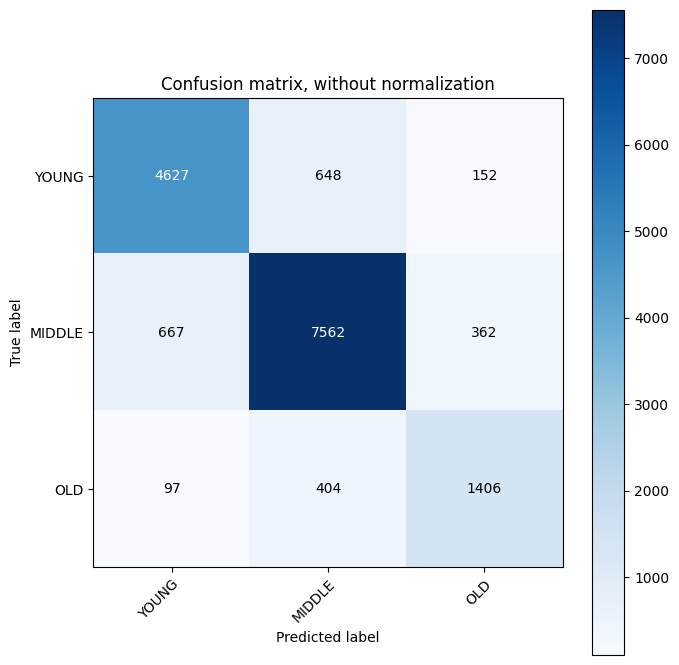

In [ ]:
# plotting confusion matrix without normalization
plot_confusion_matrix(y_labels, test_response, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

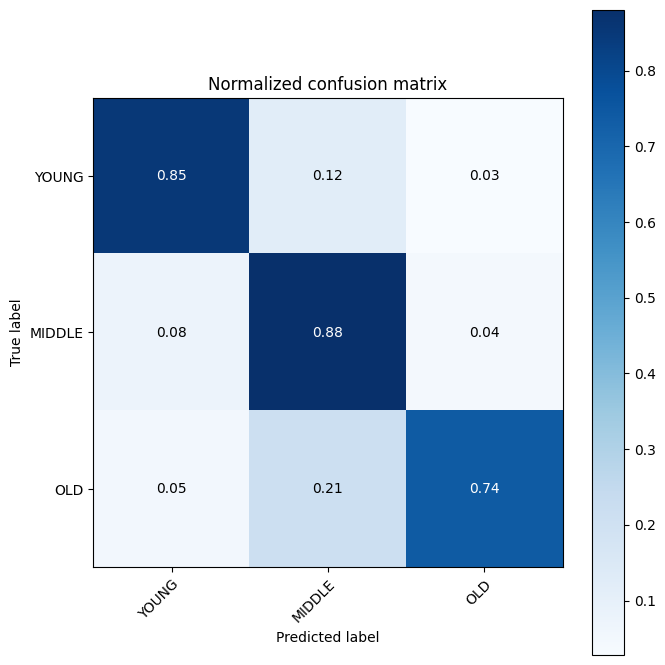

In [ ]:
# plotting confusion matrix with normalization
plot_confusion_matrix(y_labels, test_response, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
cnn_model.save('/content/drive/MyDrive/Colab Notebooks/Face_Age_Detection.h5')

In [ ]:
import cv2
import numpy as np
print(cv2.__version__)

4.7.0


In [ ]:
image_path = '/content/Train/0.jpg'

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

with open('/content/face_info.xml', 'w') as f:
    f.write('<faces>\n')
    for (x, y, w, h) in faces:
        f.write('  <face>\n')
        f.write('    <x>{}</x>\n'.format(x))
        f.write('    <y>{}</y>\n'.format(y))
        f.write('    <width>{}</width>\n'.format(w))
        f.write('    <height>{}</height>\n'.format(h))
        f.write('  </face>\n')
    f.write('</faces>')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def plot_model_history(history):
    # Plot accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [ ]:
history = cnn_model.fit(train_set, epochs=100, validation_data=test_set)
plot_model_history(history)

In [ ]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(model_history.history[acc]) + 1), model_history.history[acc])
    axs[0].plot(range(1, len(model_history.history[val_acc]) + 1), model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history[acc]) + 1), len(model_history.history[acc]) / 10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']) / 10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    plt.savefig('roc.png')

In [ ]:
history = cnn_model.fit(train_set, epochs=10, validation_data=test_set)
plot_model_history(history)